# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
%matplotlib inline
# Import libraries

import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1] - 1
n_passed = student_data[student_data['passed']=='yes'].shape[0]
n_failed = student_data[student_data['passed']=='no'].shape[0]
grad_rate = float(n_passed)/float(n_students) * 100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [6]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train
training_sizes = [100, 200, 300]
test_sizes = [1-100.0/num_all, 1-200.0/num_all, 1-300.0/num_all]
print test_sizes

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_all, y_all, test_size=test_sizes[2], random_state=50)
print "Training set: {} samples".format(X_train_o.shape[0])
print "Test set: {} samples".format(X_test_o.shape[0])
# Note: If you need a validation set, extract it from within training data

[0.7468354430379747, 0.49367088607594933, 0.240506329113924]
Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [7]:
# Train a model
import time

def train_classifier(clf, X_train, y_train, stats=None, cf_short_name = None):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    trt = end - start
    if stats is not None and cf_short_name is not None:
        stats[cf_short_name]['trt'].append("{:.3f}".format(trt))
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)


# TODO: Choose a model, import it and instantiate an object
#import matplotlib.pyplot as plt
#from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

clf_sgd = SGDClassifier(loss='log', penalty='l2')
clf_svm = SVC(kernel='rbf', probability=True, C=1)
clf_gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=50)
clf = SGDClassifier(loss='log', penalty='l2')

# Fit model to training data
train_classifier(clf, X_train_o, y_train_o)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

Training SGDClassifier...
Done!
Training time (secs): 0.001
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [8]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, stats=None, cf_short_name = None, training=True):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    prt = end - start    
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    f1 = f1_score(target.values, y_pred, pos_label='yes')
    if stats is not None and cf_short_name is not None:
        if training == True:
            stats[cf_short_name]['f1tr'].append("{:.3f}".format(f1))
        else:
            stats[cf_short_name]['f1ts'].append("{:.3f}".format(f1))
            stats[cf_short_name]['prt'].append("{:.3f}".format(prt))
            
    return f1


train_f1_score = predict_labels(clf, X_train_o, y_train_o)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using SGDClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.262548262548


In [9]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test_o, y_test_o))

Predicting labels using SGDClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.25


In [10]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test, stats=None, cf_short_name = None):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train, stats, cf_short_name)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train, stats, cf_short_name, training=True))
    f1 = predict_labels(clf, X_test, y_test, stats, cf_short_name, training=False)
    print "F1 score for test set: {}".format(f1)
    return f1

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
print '--------------------Begin Size-------------------------------'
sgd = {'trt': [], 'prt': [], 'f1tr': [], 'f1ts': []}
svm = {'trt': [], 'prt': [], 'f1tr': [], 'f1ts': []}
gbt = {'trt': [], 'prt': [], 'f1tr': [], 'f1ts': []}
stats = {'sgd': sgd, 'svm': svm, 'gbt': gbt}

for testsize in test_sizes:
    print testsize * 100, " percentage test size"
    X_train, Xp_test, y_train, yp_test = train_test_split(X_all, y_all, test_size=testsize, random_state=50)
    f1 = train_predict(clf_sgd, X_train, y_train, X_test_o, y_test_o, stats=stats, cf_short_name = 'sgd')
    f1 = train_predict(clf_svm, X_train, y_train, X_test_o, y_test_o, stats=stats, cf_short_name = 'svm')
    f1 = train_predict(clf_gbt, X_train, y_train, X_test_o, y_test_o, stats=stats, cf_short_name = 'gbt')



--------------------Begin Size-------------------------------
74.6835443038  percentage test size
------------------------------------------
Training set size: 100
Training SGDClassifier...
Done!
Training time (secs): 0.001
Predicting labels using SGDClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.853801169591
Predicting labels using SGDClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.751677852349
------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.004
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.848837209302
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.75
------------------------------------------
Training set size: 100
Training GradientBoostingClassifier...
Done!
Training time (secs): 0.056
Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs):

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
# TODO: Train and predict using two other models
######## please see the previous section as it combines all three models for all sizes considered
print "all stats"
print stats


all stats
{'gbt': {'f1ts': ['0.768', '0.791', '0.766'], 'prt': ['0.000', '0.000', '0.000'], 'trt': ['0.056', '0.085', '0.090'], 'f1tr': ['1.000', '0.990', '0.972']}, 'svm': {'f1ts': ['0.750', '0.765', '0.783'], 'prt': ['0.001', '0.002', '0.003'], 'trt': ['0.004', '0.020', '0.041'], 'f1tr': ['0.849', '0.852', '0.860']}, 'sgd': {'f1ts': ['0.752', '0.395', '0.000'], 'prt': ['0.000', '0.000', '0.000'], 'trt': ['0.001', '0.001', '0.001'], 'f1tr': ['0.854', '0.355', '0.000']}}


### Three Models and Their Output

|*Model*|*General Usage*|*Pros*|*Cons*|
|:-----:|:-------------:|:----:|:----:|
| Stocahastic Gradient |Uses simple and effective algorithm to classify or regress features| 1) Very efficient 2) Simple and easy to implement| 1) Number of iterations required to adjust hyper parameters (model intrinsic) 2) Sensitive to feature scaling like neural network based algorithms |
| SVM Logistic Classifier|Effective Linear and Non Linear Algorithms to classify or regress features| 1) Handles high dimensionality effectively 2) Memory efficient 3) Versatile (plug any suitable kernel)| 1) Costly probability measures 2) Low predictive power if features greater than sample size|
| Gradient Tree Boosting Classifier |Generalizes boosting over arbitrary differentiable loss functions| 1) Handles heterogenous features 2) High predictive power 3) Handles Outliers Efficiently| 1) Unscalable and cannot be parallelized|


#### SGD
|*Stat*|*100*|*200*|*300*|
|:---:  |:---:|:---:|:---: |
|Training Time|0.001|0.001|0.001|
|Predition Time|0.001|0.001|0.001|
|F1 Score Training|0.844|0.844|0.484|
|F1 Score Testing|0.750|0.760|0.416|


#### SVM
|*Stat*|*100*|*200*|*300*|
|:---:  |:---:|:---:|:---: |
|Training Time|0.004|0.020|0.043|
|Predition Time|0.001|0.001|0.003|
|F1 Score Training|0.104|0.100|0.092|
|F1 Score Testing|0.750|0.765|0.783|

#### GBT
|*Stat*|*100*|*200*|*300*|
|:---:  |:---:|:---:|:---: |
|Training Time|0.054|0.088|0.101|
|Predition Time|0.001|0.001|0.001|
|F1 Score Training|0.104|0.100|0.092|
|F1 Score Testing|0.768|0.791|0.766|


#### Graph






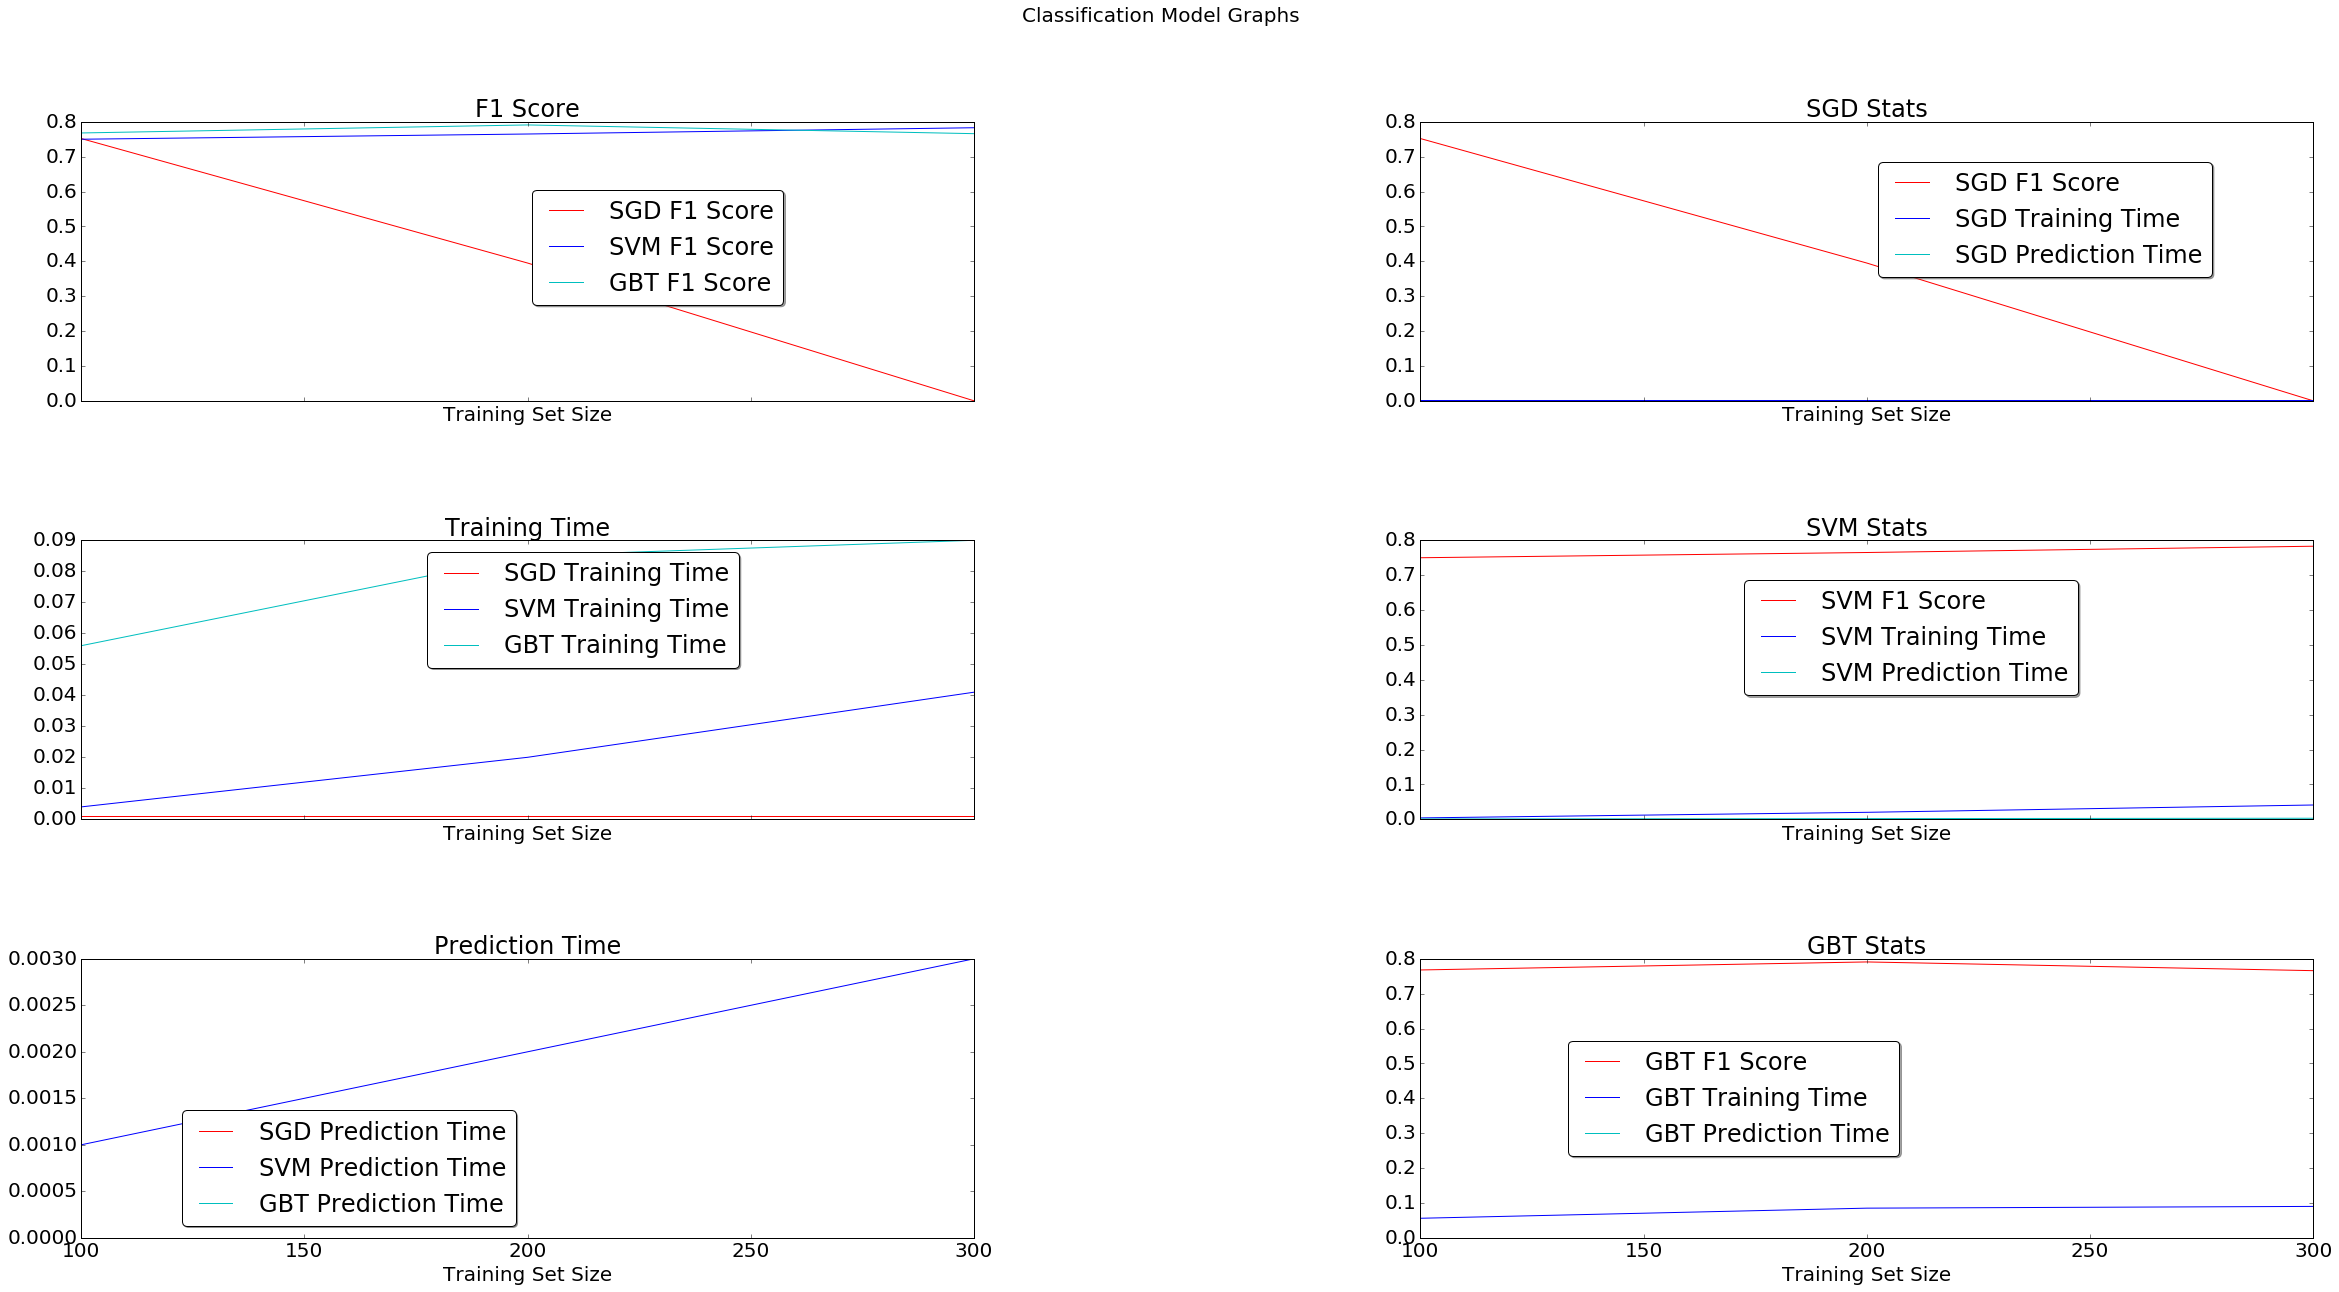

In [12]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 20})
fig, axarray = plt.subplots(3, 2, sharex=True, figsize=(40, 20), dpi=600)
plt.subplots_adjust(wspace=0.5, hspace=0.5)


f1_sgd = [float(x) for x in stats['sgd']['f1ts']]
#print "f1_sgd ", f1_sgd
f1_svm = [float(x) for x in stats['svm']['f1ts']]
#print "f1_svm ", f1_svm
f1_gbt = [float(x) for x in stats['gbt']['f1ts']]
#print "f1_gbt ", f1_gbt
trt_sgd = [float(x) for x in stats['sgd']['trt']]
#print "trt_sgd ", trt_sgd
trt_svm = [float(x) for x in stats['svm']['trt']]
#print "trt_svm ", trt_svm
trt_gbt = [float(x) for x in stats['gbt']['trt']]
#print "trt_gbt ", trt_gbt

prt_sgd = [float(x) for x in stats['sgd']['prt']]
prt_svm = [float(x) for x in stats['svm']['prt']]
prt_gbt = [float(x) for x in stats['gbt']['prt']]

axarray[0][0].plot(training_sizes, f1_sgd, color='r', label='SGD F1 Score')
axarray[0][0].plot(training_sizes, f1_svm, color='b', label='SVM F1 Score')
axarray[0][0].plot(training_sizes, f1_gbt, color='c', label='GBT F1 Score')
axarray[0][0].set_title('F1 Score')
axarray[0][0].set_xlabel('Training Set Size')
legend = axarray[0][0].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(.80, .80))


axarray[1][0].plot(training_sizes, trt_sgd, color='r', label='SGD Training Time')
axarray[1][0].plot(training_sizes, trt_svm, color='b', label='SVM Training Time')
axarray[1][0].plot(training_sizes, trt_gbt, color='c', label='GBT Training Time')
axarray[1][0].set_title('Training Time')
axarray[1][0].set_xlabel('Training Set Size')
legend = axarray[1][0].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(0.75, 1.0))



axarray[2][0].plot(training_sizes, prt_sgd, color='r', label='SGD Prediction Time')
axarray[2][0].plot(training_sizes, prt_svm, color='b', label='SVM Prediction Time')
axarray[2][0].plot(training_sizes, prt_gbt, color='c', label='GBT Prediction Time')
axarray[2][0].set_title('Prediction Time')
axarray[2][0].set_xlabel('Training Set Size')
legend = axarray[2][0].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(0.5, 0.5))


axarray[0][1].plot(training_sizes, f1_sgd, color='r', label='SGD F1 Score')
axarray[0][1].plot(training_sizes, trt_sgd, color='b', label='SGD Training Time')
axarray[0][1].plot(training_sizes, prt_sgd, color='c', label='SGD Prediction Time')
axarray[0][1].set_title('SGD Stats')
axarray[0][1].set_xlabel('Training Set Size')
legend = axarray[0][1].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(.9, .9))

axarray[1][1].plot(training_sizes, f1_svm, color='r', label='SVM F1 Score')
axarray[1][1].plot(training_sizes, trt_svm, color='b', label='SVM Training Time')
axarray[1][1].plot(training_sizes, prt_svm, color='c', label='SVM Prediction Time')
axarray[1][1].set_title('SVM Stats')
axarray[1][1].set_xlabel('Training Set Size')
legend = axarray[1][1].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(0.75, .9))

axarray[2][1].plot(training_sizes, f1_gbt, color='r', label='GBT F1 Score')
axarray[2][1].plot(training_sizes, trt_gbt, color='b', label='GBT Training Time')
axarray[2][1].plot(training_sizes, prt_gbt, color='c', label='GBT Prediction Time')
axarray[2][1].set_title('GBT Stats')
axarray[2][1].set_xlabel('Training Set Size')
legend = axarray[2][1].legend(loc='upper right', shadow=True, fancybox=True, bbox_to_anchor=(0.55, .75))

plt.suptitle('Classification Model Graphs')

plt.show()


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
   * The experiment involves testing models on three factors: 1) Time to Train, 2) Time to Predict and 3) F1 Score Time to train will on a high level compare the model's complexity as in big O levels. Since all the model testing is done on the same machine the relative comparison of this time will cover model complexity. Time to predict is as crucial as Time to train and covers the model's ability to apply what was learnt and give its opinion on a new set of data. F1 Score covers the model's ability to correctly identify the category of data. The closer the score is to One (1), the better.*
   * Based on the results and graphs, we chose __SupportVectorMachines(SVM)__ model. This model shows the __highest F1 Score__ in a larger training sample (300) and a consistent increase in performance with an increase in training set size (pls see graph above). It comes with a __negligible prediction time__. The training time of this model is modest at best. Although GradientBoosting showed a higher F1 score in smaller data sets, it also slides down as the data set size increases. The fact that this model uses lesser resources than _GBT_ and still shows closer or more accuracy (F1 Score), we are better off with this model than any other chosen here.*
   
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
   * This model works by chosing the most important factors / features that drive data and uses those selected features to determine the prediction measure. By selecting the most influencial data set from the entire data set, it tends to look past the outliers and focuses on remembering memory patterns on the chosen set. This enhances the performance of this model and reduces variability of its prediction from one data set to another. The more data it uses to train these memory patterns, the more robust it becomes.
   * Once the memory pattern is remembered, the new set of data is mapped to it and a prediction is given on that new data set.
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?
   * Final score is __0.802__. It is __higher__ than the non optimized version __0.783__.

In [16]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV
params = {'kernel': ('rbf', 'sigmoid', 'linear'), \
          'C': [x for x in np.arange(0.1, 1.1, 0.1)], \
          'gamma': [x for x in np.arange(0.1, 1.1, 0.1)],\
         }
gs = GridSearchCV(estimator = clf_svm, param_grid = params, verbose=1, n_jobs=8)
print "fitting"
gs.fit(X_train_o, y_train_o)
print "fitted"
params = gs.best_params_
print "params: ", params
y_pred = gs.predict(X_test_o)
print "predicted"
f1 = f1_score(y_test_o.values, y_pred, pos_label='yes')
print "scoring..."
print f1
print "------"



fitting
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:    4.4s finished


fitted
params:  {'kernel': 'linear', 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
predicted
scoring...
0.802919708029
------
